In [113]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from tqdm import tqdm
import re

In [114]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

# users

In [115]:
users = pd.read_csv('../main_code/data/users.csv')

In [116]:
# USERS ----------------------------------------
def fix_location(location: str, right_location: pd.Series) -> str:
    try:
        if right_location.loc[location]:
            return location
        else:
            return right_location.index[0]
    except:
        return right_location.index[0]


def location_preprocessing_func(users: pd.DataFrame) -> pd.DataFrame:
    """
    users의 location을 나누고 정리하는 함수
    1. city, state, country로 나누고
    2. country, city가 같다면 state도 같다는 점을 이용해 state를 채움
    3. country, state, city 중 하나라도 na인 row를 삭제
    4. country 이상한 애들 직접 수정
    """

    # (1) city, state, country를 나눔
    users["location"] = users["location"].str.replace(r"[^0-9a-zA-Z,]", "")  # 특수문자 제거

    users["location_city"] = users["location"].apply(lambda x: x.split(",")[0].strip())
    users["location_state"] = users["location"].apply(lambda x: x.split(",")[1].strip())
    users["location_country"] = users["location"].apply(
        lambda x: x.split(",")[2].strip()
    )

    users = users.replace(
        "na", np.nan
    )  # 특수문자 제거로 n/a가 na로 바뀌게 되었습니다. 따라서 이를 컴퓨터가 인식할 수 있는 결측값으로 변환합니다.
    users = users.replace(
        "", np.nan
    )  # 일부 경우 , , ,으로 입력된 경우가 있었으므로 이런 경우에도 결측값으로 변환합니다.

    modify_location = users[
        (users["location_country"].isna()) & (users["location_city"].notnull())
    ]["location_city"].values
    location = (
        users[
            (users["location"].str.contains("seattle"))
            & (users["location_country"].notnull())
        ]["location"]
        .value_counts()
        .index[0]
    )

    location_list = []
    for location in modify_location:
        try:
            right_location = (
                users[
                    (users["location"].str.contains(location))
                    & (users["location_country"].notnull())
                ]["location"]
                .value_counts()
                .index[0]
            )
            location_list.append(right_location)
        except:
            pass

    for location in location_list:
        users.loc[
            users[users["location_city"] == location.split(",")[0]].index,
            "location_state",
        ] = location.split(",")[1]
        users.loc[
            users[users["location_city"] == location.split(",")[0]].index,
            "location_country",
        ] = location.split(",")[2]

    # (2) country, city가 같다면 state도 같다는 점을 이용해 state를 채움
    modify_city = users["location_city"].unique()
    for city in tqdm(modify_city):
        try:
            right_state = users[
                (users["location"].str.contains(city))
                & (users["location_state"].notnull())
            ]["location_state"].value_counts()
            right_country = users[
                (users["location"].str.contains(city))
                & (users["location_country"].notnull())
            ]["location_country"].value_counts()

            right_state = right_state / right_state.sum() > 0.08
            right_country = right_country / right_country.sum() > 0.08

            modify_index = users.loc[users["location_city"] == city].index

            users.loc[modify_index, "location_state"] = users.loc[
                modify_index, "location_state"
            ].apply(fix_location, args=(right_state,))
            users.loc[modify_index, "location_country"] = users.loc[
                modify_index, "location_country"
            ].apply(fix_location, args=(right_country,))

        except:
            pass

    # # (3) na인 row를 삭제
    # users = users.dropna(
    #     subset=["location_state", "location_city", "location_country"]
    # ).reset_index(drop=True)
    
    users['location_country'] = users['location_country'].fillna('others')
    

    # (4) country 이상한 애들 직접 수정
    country_fix_dict = {
        "usa": {
            "oklahoma",
            "districtofcolumbia",
            "connecticut",
            "worcester",
            "aroostook",
            "texas",
            "kern",
            "orangeco",
            "unitedstatesofamerica",
            "fortbend",
            "alachua",
            "massachusetts",
            "arizona",
            "austin",
            "hawaii",
            "ohio",
            "camden",
            "arkansas",
            "minnesota",
            "losestadosunidosdenorteamerica",
            "us",
            "usanow",
            "northcarolina",
            "maine",
            "colorado",
            "oklahoma",
            "alabama",
            "anystate",
            "districtofcolumbia",
            "unitedstaes",
            "pender",
            "newhampshire",
            "unitedstates",
            "missouri",
            "idaho",
            "ca",
            "newyork",
            "tennessee",
            "stthomasi",
            "dc",
            "washington",
            "illinois",
            "california",
            "michigan",
            "iowa",
            "maryland",
            "newjersey",
            "vanwert",
            "oregon",
        },
        "uk": {
            "alderney",
            "wales",
            "aberdeenshire",
            "bermuda",
            "nottinghamshire",
            "scotland",
            "usacurrentlylivinginengland",
            "england",
            "countycork",
            "alderney",
            "cambridgeshire",
            "middlesex",
            "northyorkshire",
            "westyorkshire",
            "cocarlow",
            "sthelena",
        },
        "japan": {"okinawa"},
        "southkorea": {"seoul"},
        "canada": {
            "ontario",
            "alberta",
            "novascotia",
            "newfoundland",
            "newbrunswick",
            "britishcolumbia",
        },
        "miyanma": {"burma"},
        "newzealand": {"auckland", "nz", "otago"},
        "spain": {
            "andalucia",
            "pontevedra",
            "gipuzkoa",
            "lleida",
            "catalunyaspain",
            "galiza",
            "espaa",
        },
        "germany": {"niedersachsen", "deutschland"},
        "brazil": {"disritofederal"},
        "switzerland": {"lasuisse"},
        "italy": {"veneziagiulia", "ferrara", "italia"},
        "australia": {"nsw", "queensland", "newsouthwales"},
        "belgium": {"labelgique", "bergued"},
        "uruguay": {"urugua"},
        "panama": {"republicofpanama"},
    }
    country_del_list = [
        "c",
        "space",
        "universe",
        "unknown",
        "quit",
        "tdzimi",
        "universe",
        "tn",
        "unknown",
        "space",
        "c",
        "franciscomorazan",
        "petrolwarnation",
        "ineurope",
        "hereandthere",
        "faraway",
    ]
    del_idx = []
    for idx, row in enumerate(users["location_country"]):
        for key, value in country_fix_dict.items():
            if row in value:
                users.at[idx, "location_country"] = key
        if row in country_del_list:
            del_idx.append(idx)
    # users = users.drop(del_idx, axis=0).reset_index(drop=True)
    for i in del_idx:
        users.at[i, 'location_country'] = 'others'

    return users

In [117]:
users = location_preprocessing_func(users)

/tmp/ipykernel_91318/2744620385.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  users["location"] = users["location"].str.replace(r"[^0-9a-zA-Z,]", "")  # 특수문자 제거
100%|██████████| 11995/11995 [13:53<00:00, 14.39it/s]


In [128]:
users = users.drop(['location', 'location_city', 'location_state'], axis = 1)

In [133]:
users['location_country'].value_counts().head(10)

usa              45412
canada            6548
germany           3649
unitedkingdom     3121
australia         1850
spain             1700
italy              843
france             817
newzealand         467
switzerland        442
Name: location_country, dtype: int64

In [134]:
users_country = ['usa', 'canada', 'germany', 'unitedkingdom', 'australia', 'spain', 'france'] # italy 빠짐
for i in range(len(users)):
    if users.at[i, 'location_country'] not in users_country:
        users.at[i, 'location_country'] = 'others'

In [135]:
users['location_country'].value_counts().head(10)

usa              45412
canada            6548
others            4995
germany           3649
unitedkingdom     3121
australia         1850
spain             1700
france             817
Name: location_country, dtype: int64

In [137]:
users

,user_id,age,location_country
0,8,NaN,canada
1,11400,49.0,canada
2,11676,NaN,others
3,67544,30.0,canada
4,85526,36.0,canada
...,...,...,...
68087,278376,54.0,usa
68088,278621,74.0,canada
68089,278636,NaN,usa
68090,278659,33.0,canada


In [138]:
users.to_csv('userspp.csv', index = False)

# books

In [120]:
books = pd.read_csv("../main_code/data/books.csv", encoding='utf-8')

In [118]:
def text_preprocessing_func(text : str ) -> str :
    """
    깨진 문자를 변환하고 특수문자를 삭제하는 함수
    """
    text = text.replace('Ã?Â©️','e') # 원래는 é인데 걍 e로 메움
    text = text.replace('Ã©️', 'e')
    text = text.replace('Ã?Â?','e') # 원래는 é인데 걍 e로 메움
    text = text.lower()   
    text = text.replace('ã','a')
    text = text.replace('\xa0', ' ')
    text = text.replace('â', 'a')
    text = text.replace('\n', ' ')
    text = text.replace('&#39;', "'")
    text = text.replace('&quot;', '')
    text = text.replace('à','a')
    text = text.replace('--', '-')
    text = re.sub(r'[^a-z\d ]', '', text)
    del_list = ['³', 'º', 'ª', '¼', 'µ', '¹', '²', '½']
    for del_word in del_list:
        text = text.replace(del_word, '')
    text = text.strip()
    return text

In [119]:
def year_map(x: int) -> int:
    x = int(x)
    if x > 2000:
        return 1
    elif x >= 1993 and x < 2000:
        return 2
    elif x >= 1989 and x < 1993:
        return 3
    elif x >= 1980 and x < 1989:
        return 4
    elif x >= 1970 and x < 1980:
        return 5
    else:
        return 6

In [ ]:
books['year_of_publication'] = books['year_of_publication'].astype(int)

In [96]:
books = pd.read_csv("./data/books.csv", encoding='utf-8')

In [97]:
books['book_author'] = books['book_author'].apply(text_preprocessing_func) # 작가 깨진거 수정
books['book_title'] = books['book_title'].apply(text_preprocessing_func) # 책 제목 깨진거 수정

In [98]:
books['year_of_publication'] = books['year_of_publication'].astype(int) # 출판년도를 정수로

In [73]:
books['year_of_publication'].value_counts().head(50)

2002    11669
2001    11020
1999    10480
2000    10391
2003     9430
1998     9300
1994     9058
1997     8439
1996     7853
1995     7494
1993     5554
1992     5209
1991     4692
1990     4279
2004     3771
1989     3751
1988     3473
1987     2976
1986     2616
1985     2433
1984     2214
1983     1972
1982     1848
1981     1438
1980     1088
1978      944
1979      931
1977      837
1976      697
1975      541
1974      440
1973      410
1972      366
1971      249
1970      221
1969      178
1968      124
1965       94
1966       92
1967       89
1961       76
1962       73
1964       72
1963       70
1960       65
1959       60
1953       48
1957       47
1955       45
1958       45
Name: year_of_publication, dtype: int64

In [99]:
books['year_of_publication'] = books['year_of_publication'].apply(year_map)

In [100]:
books['year_of_publication'].value_counts()

2    58178
1    35910
4    20058
3    17931
6    11857
5     5636
Name: year_of_publication, dtype: int64

In [ ]:
books[books['year_of_publication'], ]

(1900.0, 2010.0)

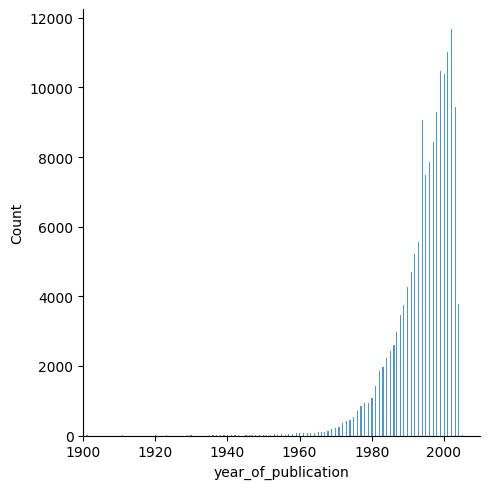

In [77]:
sns.displot(books['year_of_publication'])
plt.xlim(1900, 2010)

(1900.0, 2010.0)

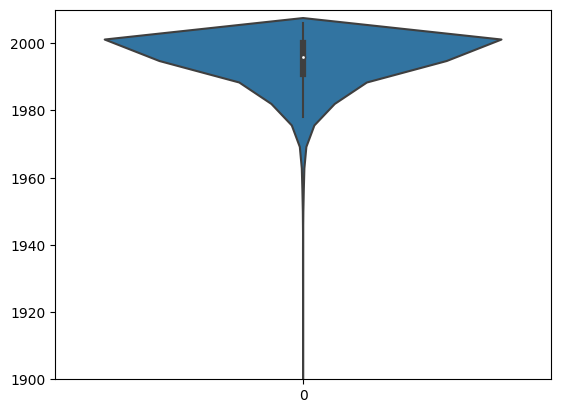

In [81]:
sns.violinplot(books['year_of_publication'])
plt.ylim(1900, 2010)

In [83]:
books['year_of_publication'].quantile([0.25, 0.5, 0.75])

0.25    1991.0
0.50    1996.0
0.75    2000.0
Name: year_of_publication, dtype: float64

In [91]:
len(books[books['year_of_publication'] < 1980])

7102

In [62]:
books = books.drop('summary', axis=1) # summary 삭제

In [63]:
groupings = {'Fiction': ['fiction', 'ficti'], # 너무 넓으니 맨 위로 빼자
             'Literature & Poem': ['liter', 'poem', 'poetry', 'novel', 'sonnet'],
             'Science & Math': ['science', 'math', 'logy', 'chemis', 'physics', 'electron'], # science, logy 범위가 너무 넓으니 맨 위로
             'Parenting & Relationships': ['baby', 'babies', 'parent', 'family', 'friend', 'tionship', 'brother', 'sister', 'families', 'friendship', 'mother', 'father'], # 좀 큼
             'Medical Books': ['medi', 'psycho'], # psy의 세분화 가능
             'Adventure' : ['adventu'],
             'Animal & Nature': ['animal', 'ecolo', 'plant', 'nature', 'cat', 'dog', 'pets', 'bird', 'bear', 'horse', 'frog', 'duck', 'rabbit', 'dolphin', 'mice', 'deer',
             'panda', 'kangaroo', 'lizzard', 'gorilla', 'chimpangee', 'bat', 'insect'],
             'Arts & Photography': ['art', 'photo', 'drawing', 'picture'], # art는 겹치는 글자가 너무 많음
             'Authors' : ['authors'],
             'Biographies & Memoirs': ['biog', 'memo'],
             'Business & Money': ['busi', 'money', 'econo', 'finance'],
             'Calendars': ['calen'],
             'Children\'s Books': ['child', 'baby'],
             'Christian Books & Bibles': ['christi', 'bible'], #크리스마스때매
             'Christmas' : ['christma'],
             'Comics & Graphic Novels': ['comics', 'graphic novel'],
             'Computers & Technology': ['computer', 'techno', 'archi'],
             'Cookbooks, Food & Wine': ['cook', 'wine', 'food'],
             'Countries & Cities' : ['united states', 'russia', 'france', 'africa', 'china', 'japan', 'egypt', 'germany', 'ireland', 'california', 'berline', 'london', 'new york', 'canada',
             'chile', 'italy', 'europe', 'australia', 'great britain', 'arizona', 'chicago', 'netherlands', 'calif', 'mexico', 'colombia', 'greece',
             'florida', 'algeria', 'new zealand', 'austria', 'denmark', 'washington', 'india', 'england', 'brazil'],
             'Crafts, Hobbies & Home': ['crafts', 'hobb', 'home', 'house', 'garden'],
             'Crime & Murder' : ['crime', 'murder', 'criminal', 'homicide', 'mafia', 'gang', 'drug'],
             'Critic' : ['critic'],
             'Education & Teaching': ['educa', 'teach'],
             'Drama' : ['drama'],
             'Design' : ['design'],
             'Engineering & Transportation': ['engine', 'transp'],
             'Encyclopedia & Dictionary' : ['encyclo', 'dictiona', 'vocabulary'],
             'Essay' : ['essay'],
             'Health, Fitness & Dieting': ['health', 'fitness', 'diet'],
             'History': ['histo', 'war'],
             'Humor & Entertainment': ['humor', 'entertai', 'comed', 'game', 'comic'],
             'Law': ['law'],
             'Language' : ['language'],
             'LGBTQ+ Books': ['lesbian', 'gay', 'bisex'],
             'Mystery, Thriller & Suspense': ['myste', 'thril', 'suspen', 'horror', 'occult'],
             'Music & Dance' : ['music', 'dance', 'instrument', 'ballet', 'classic'],
             'Movie' : ['motion pictur', 'actor', 'actres', 'acting', 'cinema', 'theater', 'director', 'television'],
             'Politics': ['politic', 'president'],
             'Philosophy' : ['philoso'],
             'Reference': ['reference'],
             'Religion & Spirituality': ['religi', 'buddh', 'spirit', 'god', 'prayer', 'belief', 'doubt'],
             'Romance': ['romance'],
             'Science Fiction & Fantasy': ['imagin', 'science fiction', 'fantasy', 'fairy', 'fairies', 'vampire', 'epidemic', 'ghost', 'alien', 'supernatural', 'magic', 'dragons', 'elves', 'angel', 'devil'],
             'Short story' : ['short'],
             'Social Science' : ['social', 'ethic', 'communism', 'capitalism', 'generation', 'culture'],
             'Self-Help': ['self'], # self 검색시 모두 자기계발 관련
             'Study': ['test', 'school', 'examina', 'study aids', 'college'],
             'Sports & Outdoors': ['exerc','sport','outdoor', 'baseball', 'soccer', 'hockey', 'cricket', 'basketball', 'footbal'],
             'Teen & Young Adult': ['teen', 'adol', 'juven'], #nonfiction이란 말은 청소년 관련뿐
             'Travel': ['travel'],
             'Women' : ['women'],
             }

In [64]:
# 카테고리 작업
books.loc[books[books['category'].notnull()].index, 'category'] = books[books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).strip()) # 일단 category에서 대괄호 밖으로 빼기
books['category'] = books['category'].str.lower() # 소문자로 바꾸기
books['category_high'] = books['category'].copy() # category_high로 category를 복사
books['category_high'] = books['category_high'].fillna('Unclassified') # 안 채워진 건 미분류 항목으로 넣기

In [65]:
for new_group, small in groupings.items(): # 파편화된 카테고리를 새 그룹으로 묶어주기
    for s in small:
        books.loc[books[books['category'].str.contains(s, na = False)].index, 'category_high'] = new_group

In [66]:
books.loc[books[books['category'].str.contains('fiction', na = False)].index, 'category_fnf'] = 'Fiction'

In [67]:
books.loc[books[books['category'].str.contains('nonfiction', na = False)].index, 'category_fnf'] = 'Nonfiction'

In [69]:
books['category_fnf'] = books['category_fnf'].fillna('Unclassified')

In [70]:
books['category_fnf'].value_counts()

Unclassified    108299
Fiction          39844
Nonfiction        1427
Name: category_fnf, dtype: int64